In [ ]:
# =========================
# LABORATORIO 1 - DataScience
# Roberto José Calderón Bermejo
# Dataset: Bank Marketing
# =========================

# --- 0) Librerías ---
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

# Config visual (simple)
plt.rcParams["figure.figsize"] = (10, 5)
sns.set_context("notebook")

In [ ]:
# --- 1) Cargar datos ---
RUTA_CSV = "dataset_banco.csv"
df = pd.read_csv(RUTA_CSV)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143.0,yes,no,unknown,5,may,261.0,1,-1.0,0,unknown,no
1,44,technician,single,secondary,no,29.0,yes,no,unknown,5,may,151.0,1,-1.0,0,unknown,no
2,33,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5,may,76.0,1,-1.0,0,unknown,no
3,47,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,92.0,1,-1.0,0,unknown,no
4,33,unknown,single,unknown,no,1.0,no,no,unknown,5,may,198.0,1,-1.0,0,unknown,no


In [ ]:
# --- 2) Inspección inicial ---
print("Filas, Columnas:", df.shape)
display(df.info())
display(df.describe(include="all").T)

# Nulos y duplicados
print("\nNulos por columna:")
display(df.isna().sum().sort_values(ascending=False))

dup = df.duplicated().sum()
print("\nDuplicados:", dup)

Filas, Columnas: (45215, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45215 entries, 0 to 45214
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        45215 non-null  int64  
 1   job        45213 non-null  object 
 2   marital    45214 non-null  object 
 3   education  45214 non-null  object 
 4   default    45215 non-null  object 
 5   balance    45213 non-null  float64
 6   housing    45215 non-null  object 
 7   loan       45215 non-null  object 
 8   contact    45215 non-null  object 
 9   day        45215 non-null  int64  
 10  month      45215 non-null  object 
 11  duration   45214 non-null  float64
 12  campaign   45215 non-null  int64  
 13  pdays      45214 non-null  float64
 14  previous   45215 non-null  int64  
 15  poutcome   45215 non-null  object 
 16  y          45215 non-null  object 
dtypes: float64(3), int64(4), object(10)
memory usage: 5.9+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,45215.0,NaN,NaN,NaN,41.004711,12.036647,18.0,33.0,39.0,48.0,776.0
job,45213,18,blue-collar,9731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,45214,6,married,27215,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,45214,10,secondary,23197,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,45215,2,no,44399,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,45213.0,NaN,NaN,NaN,1374.159866,3924.255525,-8019.0,72.0,448.0,1428.0,527532.0
housing,45215,2,yes,25132,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,45215,6,no,37962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,45215,5,cellular,29285,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,45215.0,NaN,NaN,NaN,15.805839,8.322473,1.0,8.0,16.0,21.0,31.0



Nulos por columna:


,0
job,2
balance,2
pdays,1
education,1
marital,1
duration,1
age,0
default,0
housing,0
contact,0



Duplicados: 4


In [ ]:
# --- 3) Limpieza / Normalización de categorías ---
df_clean = df.copy()

# Función segura para normalizar strings
def _norm_str(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip().str.lower()
    # Convertir "nan" string de vuelta a NaN
    s = s.replace({"nan": np.nan})
    return s

# Columnas tipo object
obj_cols = df_clean.select_dtypes(include="object").columns.tolist()
for c in obj_cols:
    df_clean[c] = _norm_str(df_clean[c])

# Mapas de categorías típicas del dataset bank (por si viene abreviado)
maps = {
    "education": {
        "admin.": "administrative",
        "sec.": "secondary",
        "ter.": "tertiary",
        "unk": "unknown"
    },
    "marital": {
        "div.": "divorced",
        "unk": "unknown"
    },
    "contact": {
        "mobile": "cellular",
        "telephone": "phone"
    }
}

for col, mp in maps.items():
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].replace(mp)

# Etiqueta objetivo (según dataset usual)
# Si tu columna objetivo tiene otro nombre, ajusta aquí.
target_candidates = ["y", "deposit", "subscribed"]
target_col = next((c for c in target_candidates if c in df_clean.columns), None)
print("Target detectada:", target_col)

Target detectada: y


In [ ]:
# --- 4) Manejo de nulos y duplicados ---
before = df_clean.shape[0]

# Opción conservadora: eliminar filas con NA (en bank marketing suelen ser pocas o ninguna)
df_clean = df_clean.dropna()

# Eliminar duplicados
df_clean = df_clean.drop_duplicates()

after = df_clean.shape[0]
print(f"Filas antes: {before}, después: {after}, removidas: {before-after}")

Filas antes: 45215, después: 45203, removidas: 12


In [ ]:
# --- 5) Separar numéricas y categóricas ---
num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df_clean.columns if c not in num_cols]

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

Numéricas: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categóricas: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


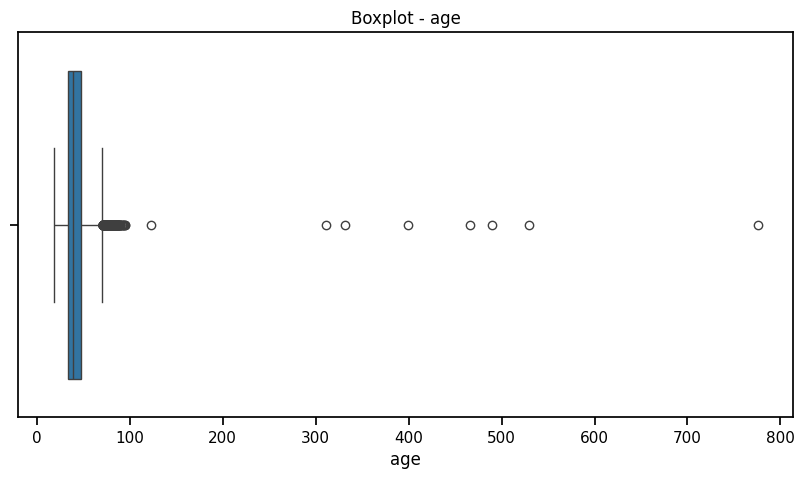

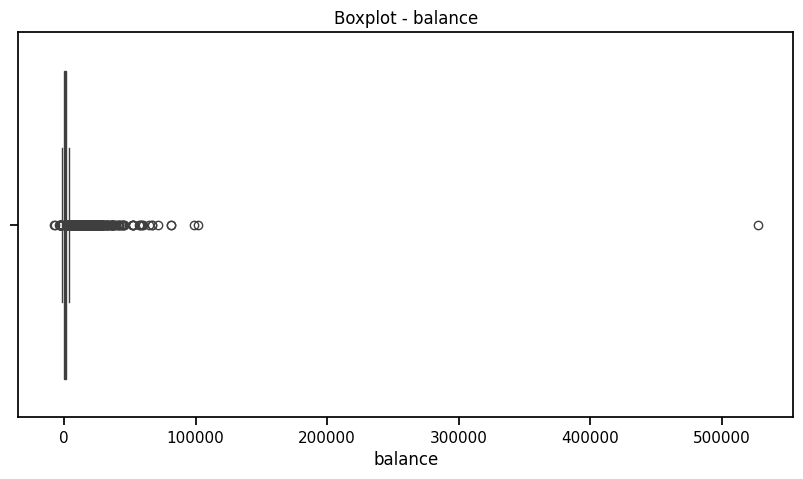

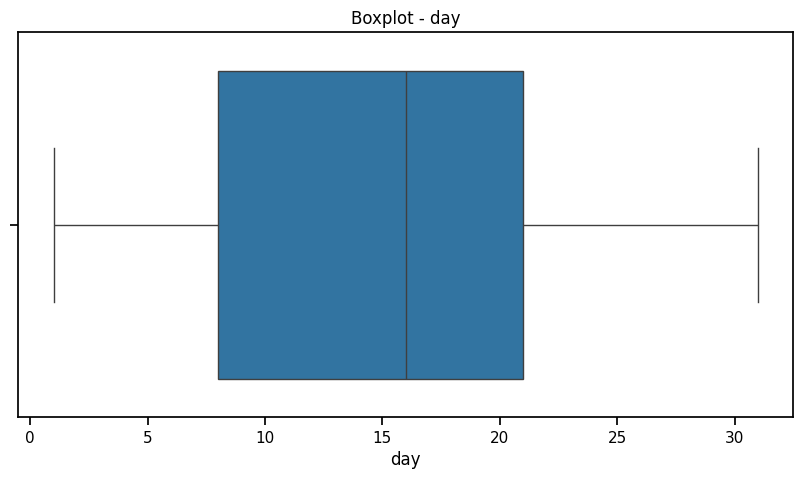

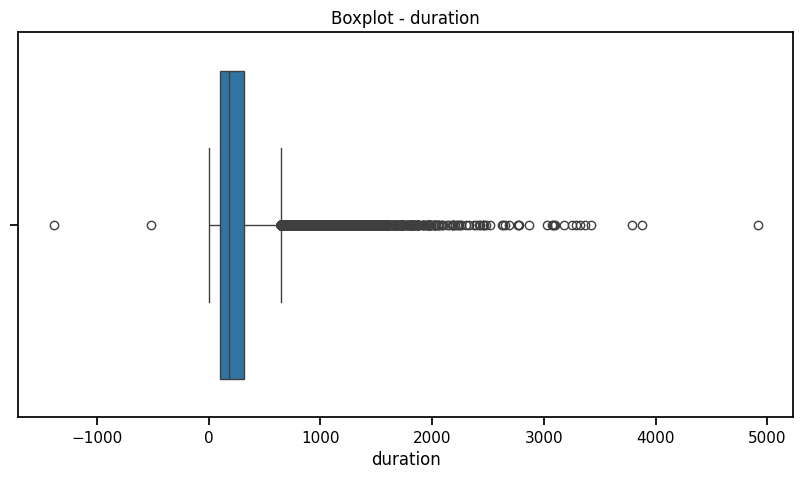

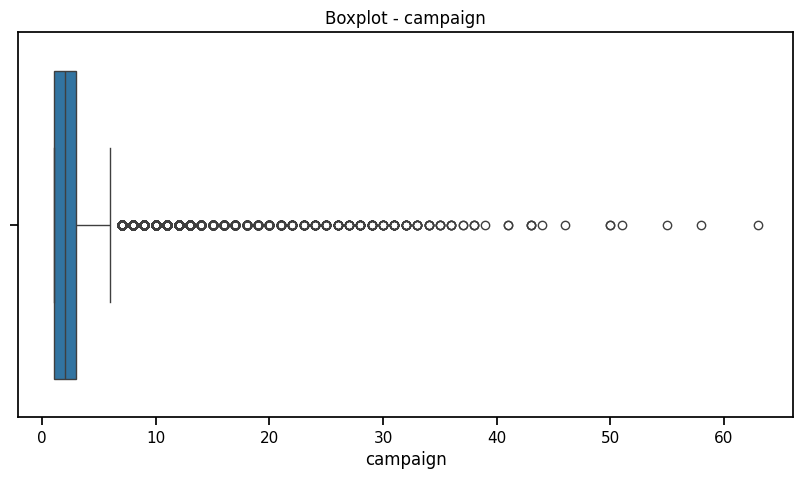

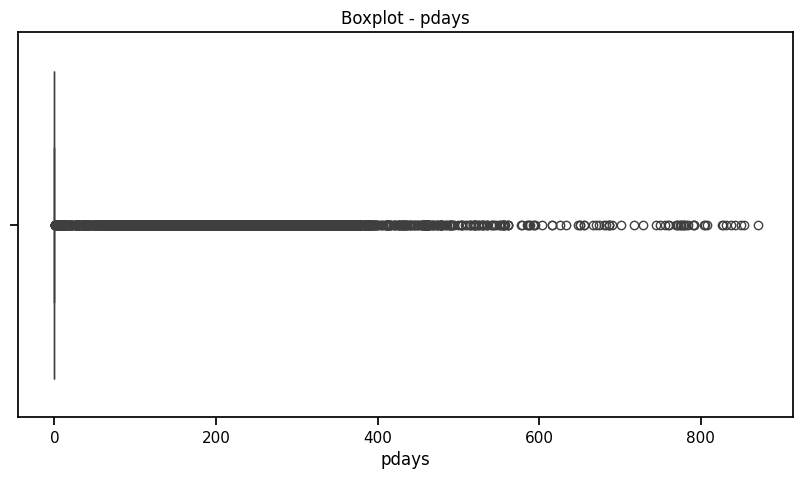

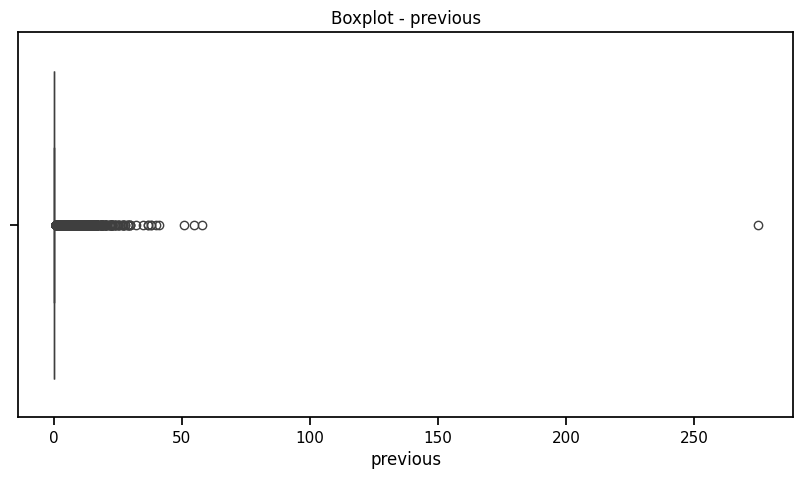

In [ ]:
# --- 6) Outliers (visualización) ---
# Boxplots de columnas numéricas (sin eliminar a ciegas)
for c in num_cols:
    plt.figure()
    sns.boxplot(x=df_clean[c])
    plt.title(f"Boxplot - {c}")
    plt.show()

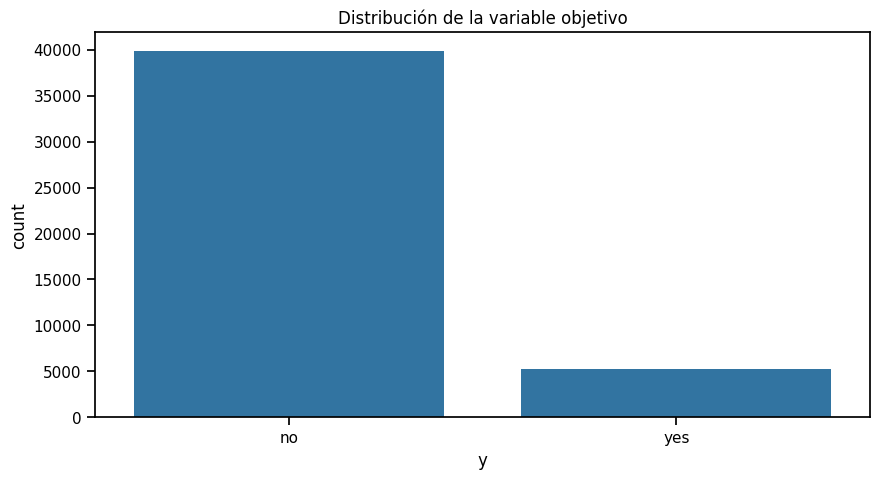

Proporciones:


,proportion
y,
no,0.883039
yes,0.116961


In [ ]:
# --- 7) Exploración de negocio

# 7.1 Distribución de la variable objetivo
if target_col is not None:
    plt.figure()
    sns.countplot(x=df_clean[target_col])
    plt.title("Distribución de la variable objetivo")
    plt.show()

    print("Proporciones:")
    display(df_clean[target_col].value_counts(normalize=True))
else:
    print("No se detectó columna objetivo. Revisa el nombre de la etiqueta (y/deposit/subscribed).")

,contact,y,prop
1,cellular,yes,0.149156
3,phone,yes,0.134251
5,unknown,yes,0.040707


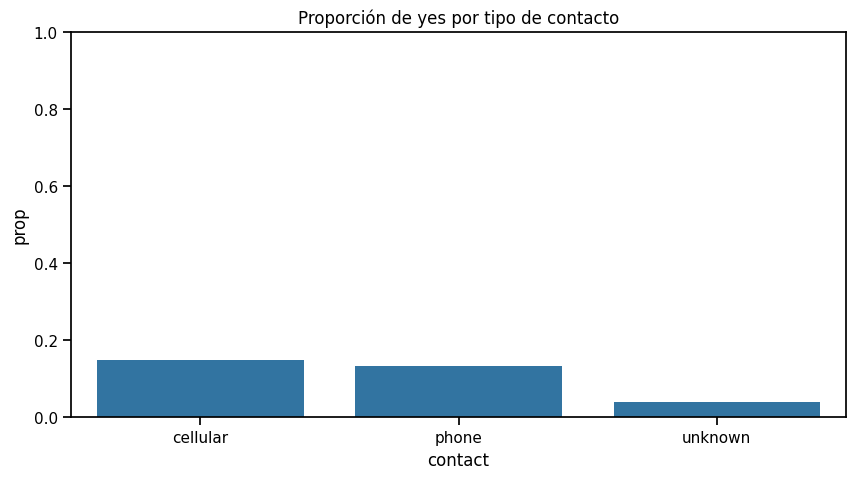

In [ ]:
# 7.2 Tasa de éxito por contacto
if target_col is not None and "contact" in df_clean.columns:
    tmp = (
        df_clean.groupby("contact")[target_col]
        .value_counts(normalize=True)
        .rename("prop")
        .reset_index()
    )
    # Nos quedamos con la clase positiva si es "yes"
    pos_label = "yes" if "yes" in df_clean[target_col].unique() else df_clean[target_col].unique()[0]
    tmp_pos = tmp[tmp[target_col] == pos_label].sort_values("prop", ascending=False)

    display(tmp_pos)

    plt.figure()
    sns.barplot(data=tmp_pos, x="contact", y="prop")
    plt.title(f"Proporción de {pos_label} por tipo de contacto")
    plt.ylim(0, 1)
    plt.show()

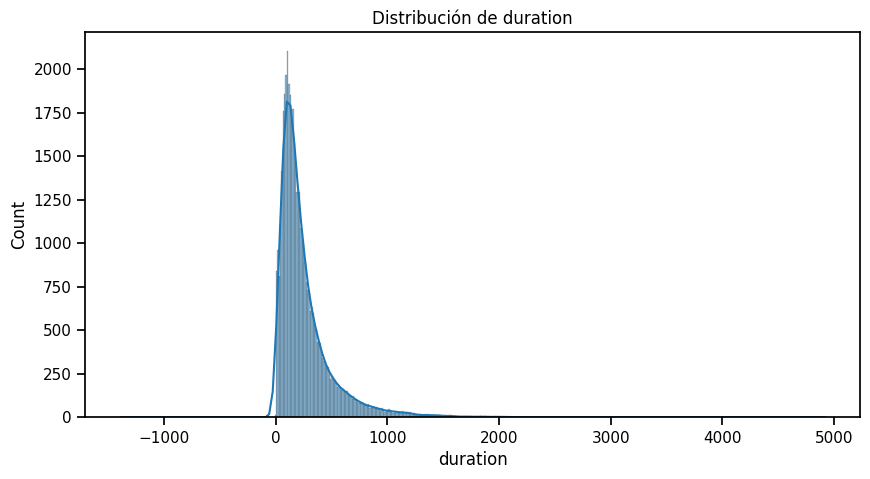

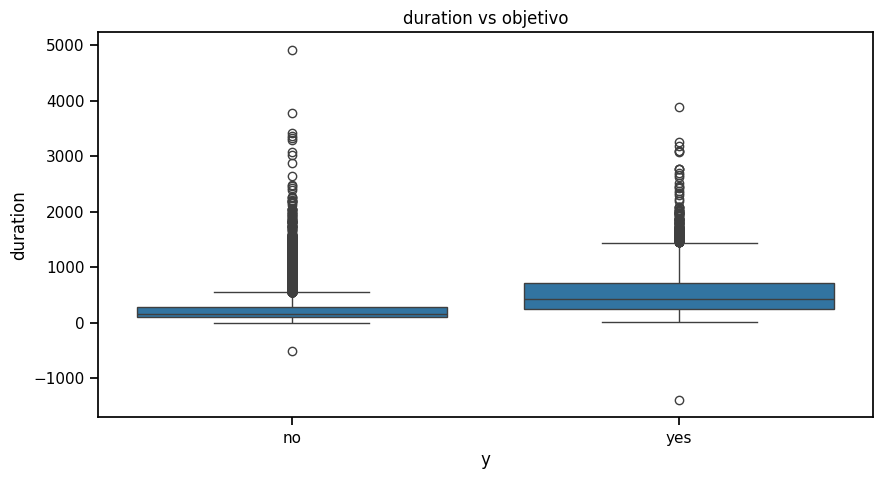

Media duration por clase:


,duration
y,
no,221.174967
yes,536.362966


In [ ]:
# 7.3 Efecto de la duración
if "duration" in df_clean.columns:
    plt.figure()
    sns.histplot(data=df_clean, x="duration", kde=True)
    plt.title("Distribución de duration")
    plt.show()

    if target_col is not None:
        plt.figure()
        sns.boxplot(data=df_clean, x=target_col, y="duration")
        plt.title("duration vs objetivo")
        plt.show()

        print("Media duration por clase:")
        display(df_clean.groupby(target_col)["duration"].mean())

In [ ]:
# 8) Modelo base (Logistic Regression)

if target_col is None:
    raise ValueError("No se detectó columna objetivo. Ajusta target_col manualmente.")

X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Preprocesamiento:
num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_features = [c for c in X_train.columns if c not in num_features]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("num", "passthrough", num_features)
    ]
)

clf = LogisticRegression(max_iter=1000)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", clf)
])

model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome']),
                                                 ('num', 'passthrough',
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'pdays', 'previous'])])),
                ('clf', LogisticRegression(max_iter=1000))])

Accuracy: 0.9020440668967348

Reporte:
               precision    recall  f1-score   support

          no       0.92      0.97      0.95      9979
         yes       0.65      0.36      0.46      1322

    accuracy                           0.90     11301
   macro avg       0.78      0.67      0.70     11301
weighted avg       0.89      0.90      0.89     11301



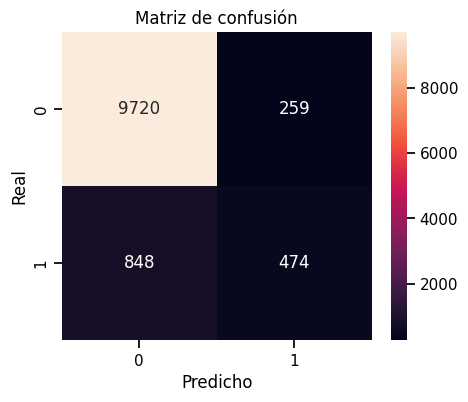

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ---- Separación
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_features = [c for c in X_train.columns if c not in num_features]

# ---- Preproceso: OneHot + Escalado numérico
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
        ("num", StandardScaler(), num_features)
    ],
    remainder="drop"
)

# ---- Modelo
clf = LogisticRegression(
    max_iter=5000,
    solver="lbfgs"
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", clf)
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Matriz de confusión")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

In [ ]:
# --- 9) Comparación rápida: con y sin 'duration' (arreglado, sin warning) ---

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def entrenar_y_evaluar(X_train, X_test, y_train, y_test):
    num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X_train.columns if c not in num_cols]

    preprocess = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
            ("num", StandardScaler(), num_cols)
        ],
        remainder="drop"
    )

    model = Pipeline(steps=[
        ("preprocess", preprocess),
        ("clf", LogisticRegression(max_iter=5000, solver="lbfgs"))
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# ---- Con duration
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

acc_con = entrenar_y_evaluar(X_train, X_test, y_train, y_test)

# ---- Sin duration (si existe)
if "duration" in X.columns:
    X2 = df_clean.drop(columns=[target_col, "duration"])
    y2 = df_clean[target_col]

    X2_train, X2_test, y2_train, y2_test = train_test_split(
        X2, y2, test_size=0.25, random_state=42, stratify=y2
    )

    acc_sin = entrenar_y_evaluar(X2_train, X2_test, y2_train, y2_test)

    print("Accuracy CON duration:", acc_con)
    print("Accuracy SIN duration:", acc_sin)
else:
    print("La columna 'duration' no existe en el dataset.")

Accuracy CON duration: 0.9020440668967348
Accuracy SIN duration: 0.8929298292186533


In [ ]:
# --- 10) Conclusiones
conclusions = []

conclusions.append(f"Tamaño final del dataset (tras limpieza): {df_clean.shape[0]} filas y {df_clean.shape[1]} columnas.")
if target_col is not None:
    dist = df_clean[target_col].value_counts(normalize=True)
    conclusions.append(f"Distribución objetivo: {dist.to_dict()}.")

if "duration" in df_clean.columns and target_col is not None:
    conclusions.append("Se observó que 'duration' suele separar fuertemente las clases; sin embargo, es potencial data leakage porque se conoce después de la llamada.")

conclusions.append(f"Baseline con regresión logística obtuvo accuracy ≈ {acc:.4f} (dependiente de la partición y limpieza).")

for i, c in enumerate(conclusions, 1):
    print(f"{i}. {c}")

1. Tamaño final del dataset (tras limpieza): 45203 filas y 17 columnas.
2. Distribución objetivo: {'no': 0.8830387363670553, 'yes': 0.11696126363294472}.
3. Se observó que 'duration' suele separar fuertemente las clases; sin embargo, es potencial data leakage porque se conoce después de la llamada.
4. Baseline con regresión logística obtuvo accuracy ≈ 0.9003 (dependiente de la partición y limpieza).


1. Tamaño final del dataset
Tras el proceso de limpieza (normalización de categorías, manejo de valores faltantes y eliminación de duplicados), el conjunto de datos quedó con 45 203 registros y 17 variables. Esto indica que la depuración no redujo drásticamente el volumen de información, por lo que el análisis posterior se realizó sobre una muestra amplia y representativa del dataset original.

2. Distribución de la variable objetivo (desbalance de clases)
La variable objetivo presenta una distribución altamente desbalanceada: aproximadamente 88.30% de los casos corresponden a “no” y solo 11.70% a “yes”. En términos prácticos, esto significa que un modelo puede alcanzar una accuracy alta simplemente prediciendo mayoritariamente “no”, pero aun así fallar al identificar correctamente los casos “yes”, que suelen ser los más relevantes en campañas de marketing (clientes que sí se suscriben).

3. "duration" como variable con posible data leakage
Se evidenció que la variable duration (duración de la llamada) separa fuertemente las clases, lo cual es consistente con la lógica del problema: llamadas más largas suelen asociarse con mayor probabilidad de suscripción. Sin embargo, duration puede introducir data leakage, porque esta información se conoce después de realizada la llamada. Si el objetivo es predecir la suscripción antes de llamar (o al inicio), entonces incluir duration produciría un desempeño artificialmente alto y poco realista para un escenario operativo.

4. Desempeño del baseline (Regresión logística)
El modelo base de regresión logística alcanzó una accuracy ≈ 0.9003, lo cual sugiere que capta adecuadamente patrones generales del conjunto de datos. No obstante, debido al desbalance de clases, esta métrica debe interpretarse con cautela: una accuracy alta no garantiza buen desempeño en la clase minoritaria (“yes”). Por ello, para evaluar mejor la capacidad del modelo de detectar suscripciones, es recomendable complementar con métricas como recall, precision y F1-score para la clase “yes”, o aplicar técnicas para tratar el desbalance (por ejemplo, class_weight="balanced").